### Audio Data preprocessing 

In [29]:
import os
import sys
import tqdm

# Get the waveform from each video
from utils.file_format import convert_mp4_to_wav

path_to_audio = './../dataset_raw/Intro/Audio/'
path_to_video = './../dataset_raw/Intro/Video/'

for video in os.listdir(path_to_video):
    convert_mp4_to_wav(path_to_video + video, path_to_audio + video[:-4] + '.wav')


MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro9.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro2.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro0.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro6.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro8.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro10.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro5.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro1.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro3.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro7.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro4.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro11.wav


MoviePy - Done.


### Exploratory Audio Data Analysis

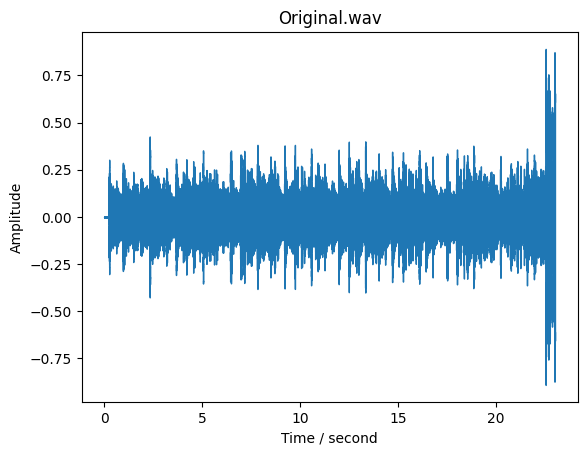

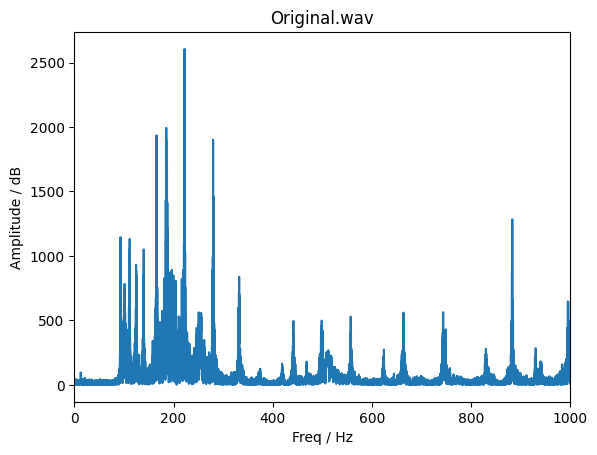

In [30]:
# Display original audio and features
from utils.data_visualization import plot_waveform, plot_frquency
import librosa
from IPython.display import Audio
import pandas as pd

audio_filepath = './../dataset_raw/Original.wav'
sample = 'Original.wav'

y, sr = librosa.load(audio_filepath, duration=23)
fig = plot_waveform(y, sr, sample)
plot_frquency(y, sr, sample)

# Playback
Audio(data=y, rate=sr)


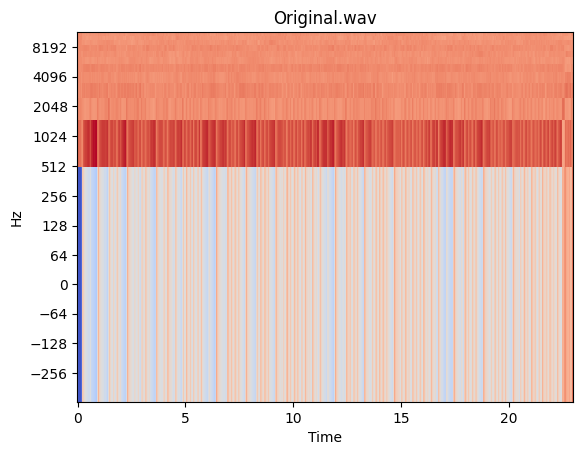

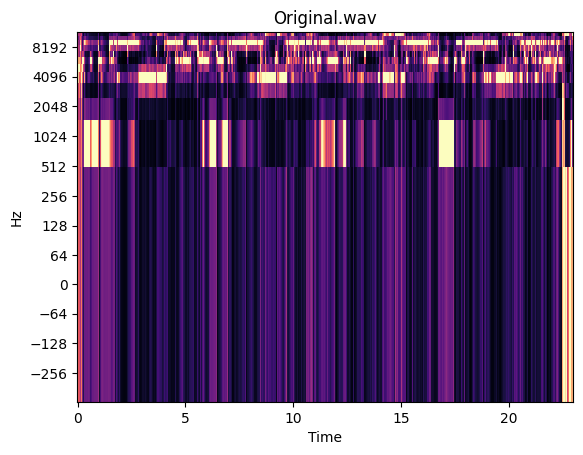

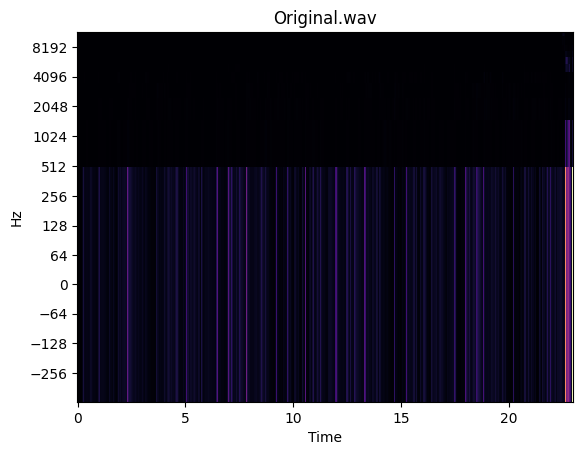

In [31]:
# Original Acoustic Features
from utils.data_visualization import plot_chromagram, plot_mel_spectrogram, plot_mfcc

plot_mfcc(y, sr, sample)
plot_chromagram(y, sr, sample)
plot_mel_spectrogram(y, sr, sample)

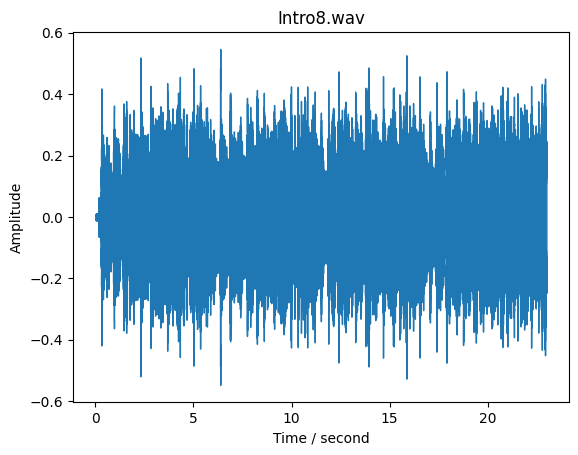

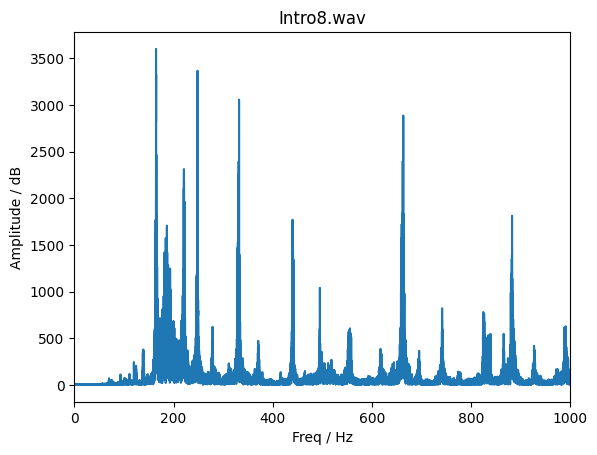

In [32]:
# Display sample audio
audio_filepath = './../dataset_raw/Intro/Audio/'
audio_files = os.listdir(audio_filepath)
audio_files = pd.DataFrame(audio_files)

sample = audio_files.sample(n=1)
sample = sample[0].values[0]

sample_path = audio_filepath + sample

y, sr = librosa.load(sample_path)
fig = plot_waveform(y, sr, sample)
plot_frquency(y, sr, sample)

Audio(data=y, rate=sr)

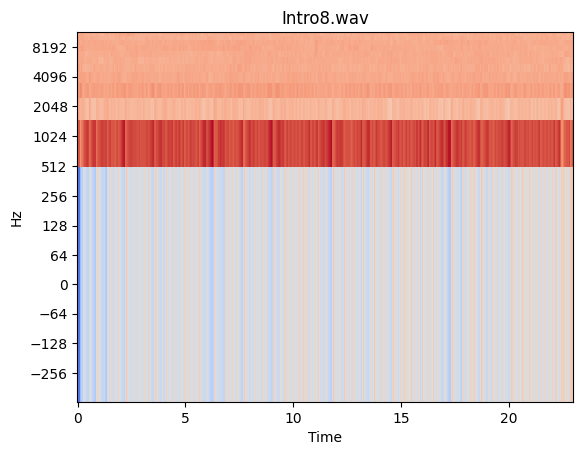

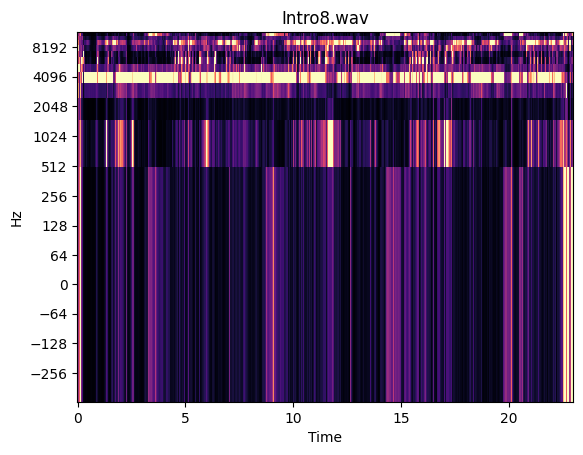

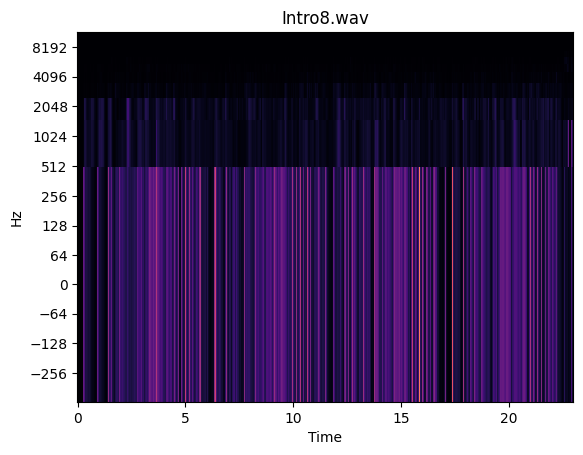

In [33]:
# Plot Audio Features

plot_mfcc(y, sr, sample)
plot_chromagram(y, sr, sample)
plot_mel_spectrogram(y, sr, sample)